## Load the model from Hugging Face Hub:

In [34]:
import os, torch, transformers
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/medicap'

dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
encoder_decoder.eval()
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)

/datasets/work/hb-mlaifsp-mm/work/environments/imageclefmedical_caption_23/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


## Pre-process images:

In [35]:
images = [
    '/datasets/work/hb-mlaifsp-mm/work/datasets/imageclef/imageclefmed_caption_2023/test/ImageCLEFmedical_Caption_2023_test_000001.jpg',
    '/datasets/work/hb-mlaifsp-mm/work/datasets/imageclef/imageclefmed_caption_2023/test/ImageCLEFmedical_Caption_2023_test_000003.jpg',
    '/datasets/work/hb-mlaifsp-mm/work/datasets/imageclef/imageclefmed_caption_2023/test/ImageCLEFmedical_Caption_2023_test_000027.jpg',
    '/datasets/work/hb-mlaifsp-mm/work/datasets/imageclef/imageclefmed_caption_2023/test/ImageCLEFmedical_Caption_2023_test_000048.jpg',
    '/datasets/work/hb-mlaifsp-mm/work/datasets/imageclef/imageclefmed_caption_2023/test/ImageCLEFmedical_Caption_2023_test_000052.jpg',
]

for i, _ in enumerate(images):
    images[i] = Image.open(images[i])
    images[i] = images[i].convert('RGB')
    images[i] = test_transforms(images[i])

images = torch.stack(images, dim=0)
images.shape

torch.Size([5, 3, 384, 384])

## Generate captions:

In [37]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=4,
)
outputs.sequences

tensor([[50257,  5377, 17128, 16667,  4867,  9367,   286,   262,  7721,  4478,
           257,  2347,   287,   262,  1364, 45105, 37646,   357,  1603,  1984,
           737, 50256, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258],
        [50257, 13450,    72,  4867,  4478,   257, 42302,  2649,   287,   262,
          1364, 44375, 27208,   357, 17585, 15452,   737, 50256, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258],
        [50257,    51,  2596,   301, 17899,   330,   291,   304,   354,   420,
         22490, 21857,  4478,   257, 42302,  2649,   287,   262,  1364,  7435,
         41001, 31643,   357, 36022, 15452,   737,  9131,    11,  1364,   379,
         1917

## Decode tokens:

In [38]:
[tokenizer.decode(i, skip_special_tokens=True) for i in outputs.sequences]

['Computed tomography scan of the chest showing a mass in the left pulmonary artery (asterisk).',
 'Angiography showing a calcification in the left renal vein (blue arrow).',
 'Transthoracic echocardiogram showing a calcification in the left ventricular cavity (yellow arrow). LA, left atrium; LV, left ventricle; RV, right ventricle.',
 'Lateral radiograph of the left wrist showing a fracture of the ulnar bone.',
 'Radiograph of the pelvis showing a fracture of the left femoral bone.']

## Corresponding images:

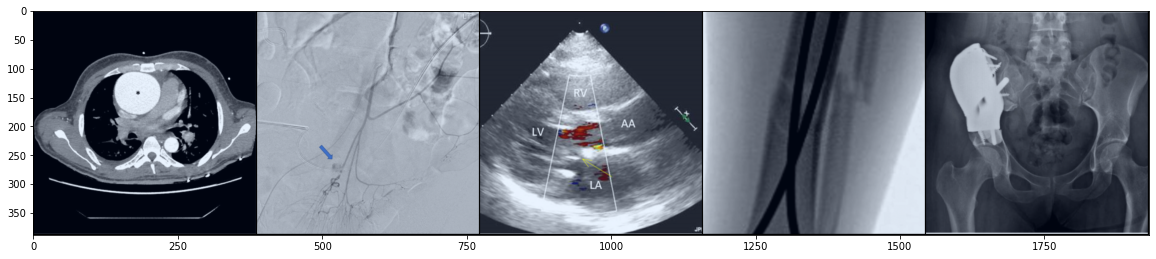

: 

In [39]:
plt.figure(figsize = (20,10))
plt.imshow(make_grid(images, normalize=True).permute(1, 2, 0))